<h1>An Example of Attention Layer Plotting</h1>

This notebook is provided to implement a simple plotting of Attention Layer.

The data is from <a href=http://www.cbs.dtu.dk/services/DeepLoc/>deeploc</a> and the presentation is provided according to the <a href=https://github.com/JJAlmagro/subcellular_localization/blob/master/notebook%20tutorial/CNN-LSTM-Attention.ipynb>notebook</a> which made by the authors of deeploc.<br> <b>To plotting the attention values</b>, the <b>training data</b> is used for predicting instead of test dataset.Thus we followed the notebook and provided a similar one.

<h2>1. Preparation</h2>

In this notebook, few packages are necessary. 

Assuming that we are in <b>'root-of-autoBioSeqpy/notebook'</b>, then we need to add the search path and import the modules.

Please install <b>keras_self_attention, matplotlib, tensorFlow and keras</b> before using this notebook.

In [1]:
import os, sys
sys.path.append('../tool/libs')
sys.path.append('../')
oriPath = os.path.curdir
import paraParser
import moduleRead
import dataProcess
#import analysisPlot
import numpy as np
#from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,confusion_matrix,matthews_corrcoef 
import tensorflow as tf
from utils import TextDecorate, evalStrList
from keras.models import Model
from keras.models import Sequential
import analysisPlot
# import umap
# import umap.plot
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

Using TensorFlow backend.


In [2]:
import keras_self_attention
from keras_self_attention import SeqSelfAttention
from keras.models import model_from_json

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

<h3>1.1 Model building</h3>

As the first step, we need a model from running.py, users could build a model by using the command line below in the root of autoBioSeqpy:

<b>python running.py --dataType protein --dataEncodingType dict  --dataTrainFilePaths ./examples/subcellular_localization/data/Cell.membrane_train.fasta ./examples/subcellular_localization/data/Cytoplasm_train.fasta ./examples/subcellular_localization/data/Endoplasmic.reticulum_train.fasta ./examples/subcellular_localization/data/Extracellular_train.fasta ./examples/subcellular_localization/data/Golgi.apparatus_train.fasta ./examples/subcellular_localization/data/Lysosome_Vacuole_train.fasta ./examples/subcellular_localization/data/Mitochondrion_train.fasta ./examples/subcellular_localization/data/Nucleus_train.fasta ./examples/subcellular_localization/data/Peroxisome_train.fasta ./examples/subcellular_localization/data/Plastid_train.fasta --dataTrainLabel 0 1 2 3 4 5 6 7 8 9 --dataTestFilePaths ./examples/subcellular_localization/data/Cell.membrane_test.fasta ./examples/subcellular_localization/data/Cytoplasm_test.fasta ./examples/subcellular_localization/data/Endoplasmic.reticulum_test.fasta ./examples/subcellular_localization/data/Extracellular_test.fasta ./examples/subcellular_localization/data/Golgi.apparatus_test.fasta ./examples/subcellular_localization/data/Lysosome_Vacuole_test.fasta ./examples/subcellular_localization/data/Mitochondrion_test.fasta ./examples/subcellular_localization/data/Nucleus_test.fasta ./examples/subcellular_localization/data/Peroxisome_test.fasta ./examples/subcellular_localization/data/Plastid_test.fasta --dataTestLabel 0 1 2 3 4 5 6 7 8 9 --modelLoadFile examples/subcellular_localization/model/protein_CNN1D+MaxPooling_bi_att.py --verbose 1 --outSaveFolderPath tmpOut_800 --savePrediction 1 --saveFig 1 --batch_size 128 --epochs 50 --spcLen 2000 --shuffleDataTrain 1 --modelSaveName tmpMod.json --weightSaveName tmpWeight.bin --noGPU 0 --paraSaveName parameters.txt --labelToMat 1 --loss categorical_crossentropy</b>

The outputs will be saved at <b>../tmpOut</b>, including the parameters, the path of the data and constructure of the model.

Alternativly, a built model is already provided in <b>./tmpOutAttention</b>, thus users could skip this step by using the provided one. (The next steps will use the generated one, please change the path if users would like to use their own.)

If users would like to use their own model, please don't forget to save the model and the weight by using parameters "--modelSaveName" and "--weightSaveName".

<b>NOTE</b>: According to our test, building and training this model need more than 30GB memory, if users would like to train the model themself, please make sure the computing device having enough memory, or reduce the 'batch_size' to a smaller one.

<h3>1.2 Parameter pasering and prediction</h3>
The parameters are saved in <b>./tmpOutAttention/parameters.txt</b>, we can get the information easily by using the <b>paraParser</b> module.

In [4]:
paraFile = './tmpOutAttention/parameters.txt'
paraDict = paraParser.parseParametersFromFile(paraFile)
#print
for k in paraDict:
    print('%r: %r' %(k,paraDict[k]))

'dataType': ['protein']
'dataEncodingType': ['dict']
'spcLen': [2000]
'firstKernelSize': []
'dataTrainFilePaths': ['./examples/subcellular_localization/data//Cell.membrane_train.fasta', './examples/subcellular_localization/data//Cytoplasm_train.fasta', './examples/subcellular_localization/data//Endoplasmic.reticulum_train.fasta', './examples/subcellular_localization/data//Extracellular_train.fasta', './examples/subcellular_localization/data//Golgi.apparatus_train.fasta', './examples/subcellular_localization/data//Lysosome_Vacuole_train.fasta', './examples/subcellular_localization/data//Mitochondrion_train.fasta', './examples/subcellular_localization/data//Nucleus_train.fasta', './examples/subcellular_localization/data//Peroxisome_train.fasta', './examples/subcellular_localization/data//Plastid_train.fasta']
'dataTrainLabel': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
'dataTestFilePaths': ['./examples/subcellular_localization/data//Cell.membrane_test.fasta', './examples/subcellular_localization/dat

Few preparing...<br>
<b>Note</b>: according to  here we using the training data for presentation, 

In [5]:
outSaveFolderPath = './tmpOutAttention/' #change this path for using other output instead of the provided

As mentioned before, the validation datasets were used for presentation, here we followed the workflow by changing the test file into training file. Since keras using 'split' for generating validation dataset automaticly, we can use the whole train dataset for predicting.

In [6]:
paraDict['dataTestFilePaths'] = paraDict['dataTrainFilePaths']
paraDict['dataTestModelInd'] = paraDict['dataTrainModelInd']
paraDict['dataTestLabel'] = paraDict['dataTrainLabel']

In [7]:
paraDict['outSaveFolderPath'] = './notebook/tmpOutAttention'

Now we changed few parameters to specify the path and dataset, then using the function in <b>predicting.py</b> could generate the predictions and the model easily.

In [8]:
import predicting

In [9]:
os.chdir('../')#to the root path of autoBioSeqpy

In [10]:
predictedLabel,predicted_Probability,testNameLists,testDataMats,testLabelArr,model = predicting.predict(paraDict)    

Enconding protein data for model 0 ...
Checking the number of test files, which should be larger than 1 (e.g. at least two labels)...
Begin to generate test dataset...
Test datasets generated.
Since labelToMat is set, the labels would be changed to onehot-like matrix
begin to prepare model...
Checking module file for modeling
Loading module and weight file
Building model...
[{'SeqSelfAttention': <class 'keras_self_attention.seq_self_attention.SeqSelfAttention'>}]
Module loaded, generating the summary of the module
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 256)         6656      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 256)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1996, 250)         320250 

<h2>2. Generating data for presentation</h2>

The layout in this section is referred to <a href=https://github.com/JJAlmagro/subcellular_localization/blob/master/notebook%20tutorial/CNN-LSTM-Attention.ipynb>the notebook of deeploc</a>,including the confusion matrix and the outputs from attention layer.

<h3>2.1 Generating the prediction</h3>
Here we provided the confusion matrix and few metrics of this prediction.

In [11]:
print(predicted_Probability.shape)

(11231, 10)


In [12]:
from sklearn.metrics import accuracy_score,confusion_matrix

Please note that using <b>predicting.py</b> will not generate the label since it is only for predicting, thus we have to generate the label in a formal way (please see the 'tutorial in jupyter notebook.ipynb' which provided in the same path for details).

In [13]:
dataLoaders = []
for i,dataPath in enumerate(paraDict['dataTestFilePaths']):
    featureGenerator =  dataProcess.ProteinFeatureGenerator('protein', useKMer=False)
    dataLoader = dataProcess.DataLoader(label = paraDict['dataTestLabel'][i], featureGenerator=featureGenerator)
    dataLoader.readFile(dataPath, spcLen = paraDict['spcLen'][0])
    dataLoaders.append(dataLoader)
testLabelArrs = []
testDataSetCreator = dataProcess.DataSetCreator(dataLoaders)
testDataMat, testLabelArr, nameList = testDataSetCreator.getDataSet(toShuffle=False, withNameList=True)
oriLabel = testLabelArr

Since we have the label, it is possible to generate the confusion matrix.

In [15]:
cm=confusion_matrix(oriLabel,predictedLabel)
print(cm)
print('ACC: %.2f%%' %(accuracy_score(oriLabel,predictedLabel)*100))

[[1011   19   11    2    2    7    6    7    1    1]
 [   2 2040    2    6    1    1   21   88   12    7]
 [  17    6  636    6    5    8    6    1    2    2]
 [   3   12    5 1551    1    1    2    5    0    0]
 [   4   13    5    0  253    4    1    5    0    1]
 [   6   21    3    4    4  215    0    2    2    0]
 [   2   10    5    1    2    1 1176    2    3    6]
 [   4  103    2    3    1    0   10 3100    6    6]
 [   0    5    2    1    0    1    3    1  110    1]
 [   0    9    1    0    0    0    6    1    1  587]]
ACC: 95.09%


Plotting the confusion matrix in figure

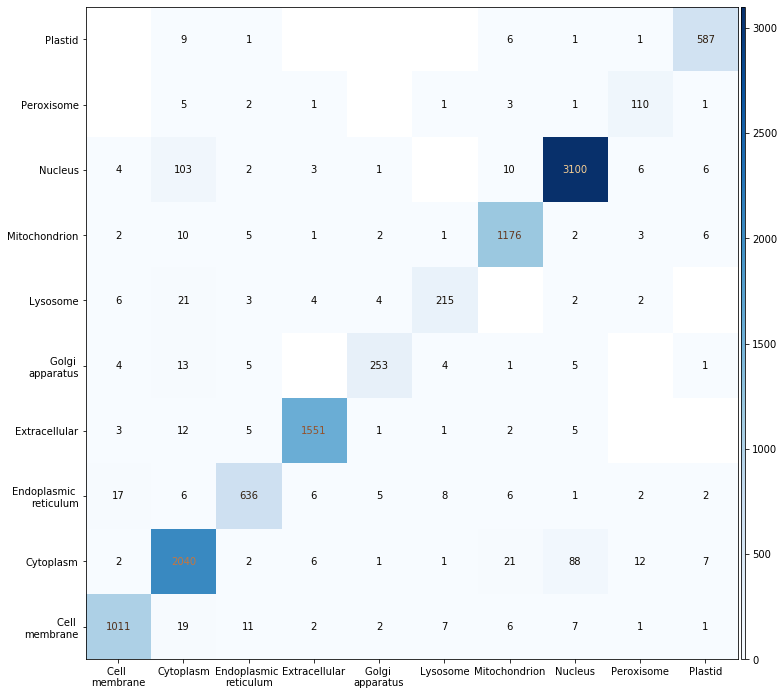

In [17]:
classes = ['Cell \nmembrane','Cytoplasm','Endoplasmic \nreticulum','Extracellular','Golgi \napparatus','Lysosome','Mitochondrion','Nucleus',
           'Peroxisome','Plastid']
analysisPlot.showMatWithVal(cm,precision='%d',xtickLabels=classes,ytickLabels=classes,toInvert=False,cmapName='Blues',figSize=(12,12))

<h3>2.2 Generating the output of attention layer</h3>

Using the submodel in section 3.1 to generate the output of attention layer. If using <b>keras_self_attention</b> for the attention layer, usually two matrix will be generated, the first is the correction with the input data (i.e. from self-attention), another is the output values (i.e. the values for next layers). Here we will use both of the outputs for plotting.

In [18]:
attModel = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('seq_self_attention_1').output])

In [19]:
att_Probability = attModel.predict(testDataMats)
print(len(att_Probability))

2


The first output:

Since the output is for self-attention, both the x- and y-axis are the 10 classes, the visualization itself will be like a confusion matrix, but a part of them will be correlated with more than one classes.

In [20]:
att1 = np.array(att_Probability[0])
att1.shape

(11231, 10)

In [23]:
y_label = np.array(testLabelArr).reshape(11231,1)
y_label_for_plotting = y_label.dot(np.ones([1,100]))
print(y_label_for_plotting.shape)
print(y_label_for_plotting)

(11231, 100)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]]


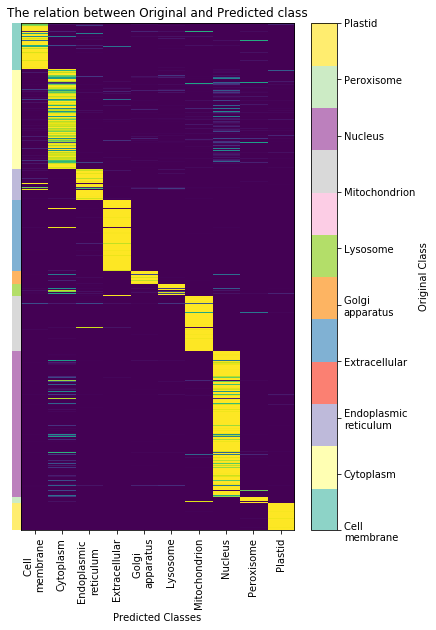

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15));

# labels_plot = ax1.imshow(y_label,cmap=plt.get_cmap('Set1'))
labels_plot = ax1.imshow(y_label_for_plotting,cmap=plt.get_cmap('Set3'))

ax1.set_aspect(0.3)
ax1.set_axis_off()
cb = plt.colorbar(labels_plot)
labels = np.arange(0,10,1)
loc = labels
cb.set_ticks(loc)
#cb.set_ticklabels(list(range(10)))
cb.set_ticklabels(classes)
cb.set_label('Original Class')
att_plot = ax2.imshow(att1, aspect='auto')
ax2.yaxis.set_visible(False)
ax2.set_xticks(labels)
ax2.set_xticklabels(classes,rotation=90)
plt.tight_layout(pad=24.5, w_pad=0.5, h_pad=1.0)
plt.xlabel('Predicted Classes')
plt.title('The relation between Original and Predicted class')
#plt.savefig('tmp2.png',dpi=600)
plt.show()

The second output:

The second output is for generating the values for the next layer, thus the dimension of the data will be higher than the first output. To make the visualization possible in 2D-plotting, some dimensional reduction operations is used.

In [25]:
att2 = np.array(att_Probability[1])
att2.shape

(11231, 998, 128)

Since the dimension is larger than 1, a flatten and sum operation was launched before plotting.

In [26]:
att2_out = []
for i in range(att2.shape[0]):
    att2_out.append(att2[i,:].flatten())
att2_out = np.array(att2_out)
print(att2_out.shape)

(11231, 127744)


In [27]:
att2_out = att2.sum(axis=1)
print(att2_out.shape)

(11231, 128)


Normalizing, but could be skiped somehow. Usually the plotting itself could do the such operation.

In [28]:
att2_out = (att2_out - att2_out.min()) / (att2_out.max() - att2_out.min())

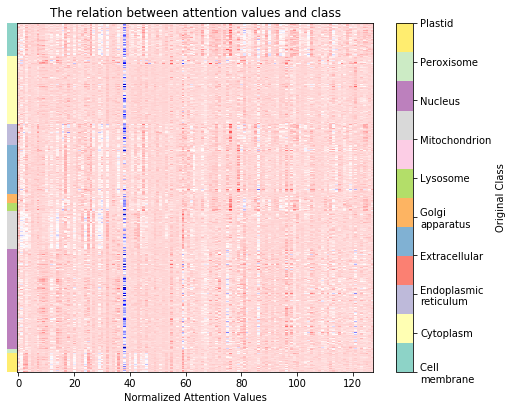

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15));

# labels_plot = ax1.imshow(y_label,cmap=plt.get_cmap('Set1'))
labels_plot = ax1.imshow(y_label_for_plotting,cmap=plt.get_cmap('Set3'))

ax1.set_aspect(0.3)
ax1.set_axis_off()
cb = plt.colorbar(labels_plot)
labels = np.arange(0,10,1)
loc = labels
cb.set_ticks(loc)
cb.set_ticklabels(classes)
cb.set_label('Original Class')
att_plot = ax2.imshow(att2_out, aspect='auto',cmap='seismic')
ax2.yaxis.set_visible(False)

plt.tight_layout(pad=35.5, w_pad=2, h_pad=1.0)
plt.xlabel('Normalized Attention Values')
plt.title('The relation between attention values and class')
#plt.savefig('tmp.tiff',dpi=600)
plt.show()


That's all the informations for plotting the output of attention layer. If you still have more issues, please fell free to connect us at ljs@swmu.edu.cn, thanks.